# Unsupervised Learning: Anomaly Detection

In [1]:
#import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pycaret.anomaly import *
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from scipy.stats import kurtosis
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import ipympl

%matplotlib inline

# Importing Data

In [2]:
df = pd.read_csv('./Data/data.csv', sep= ';')

df_original = df.copy()

# Data Transformation

## Normalizing the numerical variables

In [3]:
# normalizing the numerical behavioural variables
df_numerical = df.drop(["idnr","b2","c3","c9","c15","c18","c19","c20","c26","c29"], 1)
df_numerical_n = pd.DataFrame(preprocessing.normalize(df_numerical))
df_numerical_n.columns = df_numerical.columns

## Transforming string attributes to categorical attributes with integers

In [4]:
# conveting strings to categorical attributes to use it in the training and prrediction
df[["b2","c3","c9","c15","c18","c19","c20","c26","c29"]] = df[["b2","c3","c9","c15","c18","c19","c20","c26","c29"]].apply(lambda z: z.astype('category').cat.codes)

In [5]:
df_processed = pd.concat([df[["idnr","b2","c3","c9","c15","c18","c19","c20","c26","c29"]], df_numerical_n], 1)

# PCA for reducing the dimension of contextual variables

In [6]:
# dropping behavioural attributes and idnr 
df_contextual = df_processed.drop(["idnr", "b1", "b2", "b3", "b4"], 1)

In [7]:
# we will initially divide to 10 PCs
pca = PCA(n_components=10)
PCs = pca.fit_transform(df_contextual)
principalDf = pd.DataFrame(data = PCs, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6','PC 7', 'PC 8', 'PC 9', 'PC 10'])
principalDf

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10
0,-0.335505,-0.283181,-0.059268,0.035269,-0.018529,-0.013064,-0.004328,-0.000947,-0.000474,0.000057
1,0.298027,1.077649,-0.048181,-0.050618,0.043428,0.002958,-0.036692,0.000042,0.003584,-0.000765
2,-0.357351,-0.307636,-0.145480,0.027962,-0.017973,-0.014504,-0.000582,-0.001115,-0.000948,0.000679
3,-0.324380,-0.306372,-0.066071,-0.071212,-0.004053,-0.007897,-0.004680,-0.000867,0.001184,-0.000303
4,-0.304737,-0.285632,0.009656,-0.068382,-0.004095,-0.006450,-0.009808,-0.000716,0.001370,-0.000154
...,...,...,...,...,...,...,...,...,...,...
78759,-0.341568,-0.280418,-0.069614,0.062787,-0.022337,-0.014653,-0.003860,-0.000992,-0.000686,0.000334
78760,-0.330724,-0.270356,-0.029779,0.060036,-0.021778,-0.013681,-0.006368,-0.000909,-0.000647,-0.000124
78761,-0.334567,-0.282233,-0.055723,0.035342,-0.018547,-0.012992,-0.005527,-0.000940,-0.000486,0.000223
78762,0.243120,1.023344,-0.254657,-0.047789,0.042370,-0.001541,-0.010399,-0.000391,0.011941,0.001162


Text(0, 0.5, 'PV')

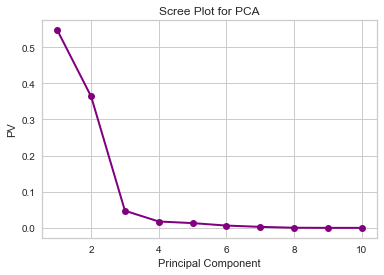

In [8]:
# drawing the Percentage Variation explained per PC
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2, color = "purple")
plt.title('Scree Plot for PCA')
plt.xlabel('Principal Component')
plt.ylabel('PV')
#plt.show()

In [9]:
# cumulative percentage variance per PC
out_sum = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)*100, columns = ["cumPV%"] ) 
print ("Cumulative PV Explained: \n", out_sum)

Cumulative PV Explained: 
       cumPV%
0  54.691843
1  91.066548
2  95.823379
3  97.602504
4  98.938767
5  99.594573
6  99.893337
7  99.946580
8  99.967522
9  99.986278


#### Elbow occures between PC3 and PC4, to keep as much as possible info we will use 4 PCs whicch explain 98% of the variation 

In [10]:
PC_contextual = principalDf[['PC 1', 'PC 2', 'PC 3', 'PC 4']]

# Updating Data with Contextual PCs

In [11]:
# combining 4PCs for contextual attributs with the scaled behavioural attributes
df_dim_reduced = pd.concat([df_processed[["idnr", "b1", "b2", "b3", "b4"]], PC_contextual],1)

In [12]:
# keeping only the features for the training
features = df_dim_reduced.drop("idnr",1)
features

,b1,b2,b3,b4,PC 1,PC 2,PC 3,PC 4
0,0.000000,17,0.111717,0.985012,-0.335505,-0.283181,-0.059268,0.035269
1,0.000000,9,0.447397,0.617834,0.298027,1.077649,-0.048181,-0.050618
2,0.000000,17,0.021192,0.999022,-0.357351,-0.307636,-0.145480,0.027962
3,0.000000,17,0.152432,0.975689,-0.324380,-0.306372,-0.066071,-0.071212
4,0.000000,17,0.198461,0.953975,-0.304737,-0.285632,0.009656,-0.068382
...,...,...,...,...,...,...,...,...
78759,0.000000,16,0.966916,0.221437,-0.341568,-0.280418,-0.069614,0.062787
78760,0.000000,16,0.971001,0.171076,-0.330724,-0.270356,-0.029779,0.060036
78761,0.000000,17,0.090380,0.986681,-0.334567,-0.282233,-0.055723,0.035342
78762,0.041845,10,0.739260,0.516087,0.243120,1.023344,-0.254657,-0.047789


In [13]:
# to identify the missiing values and type of fields
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78764 entries, 0 to 78763
Data columns (total 42 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   idnr    78764 non-null  int64  
 1   b1      78764 non-null  int64  
 2   b2      78764 non-null  int8   
 3   b3      78764 non-null  int64  
 4   b4      78764 non-null  int64  
 5   c1      78764 non-null  int64  
 6   c2      78764 non-null  int64  
 7   c3      78764 non-null  int8   
 8   c4      78764 non-null  float64
 9   c5      78764 non-null  float64
 10  c6      78764 non-null  int64  
 11  c7      78764 non-null  float64
 12  c8      78764 non-null  float64
 13  c9      78764 non-null  int8   
 14  c10     78764 non-null  float64
 15  c11     78764 non-null  float64
 16  c12     78764 non-null  float64
 17  c13     78764 non-null  int64  
 18  c14     78764 non-null  int64  
 19  c15     78764 non-null  int8   
 20  c16     78764 non-null  int64  
 21  c17     78764 non-null  int64  
 22

# Data Visualization

#### Initial Inspection of Behavioural Attributes in Isolation

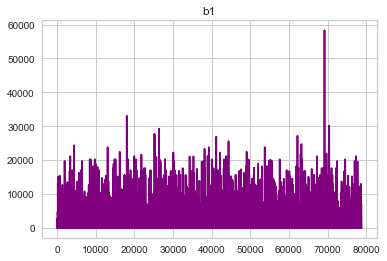

In [14]:
#plt.hist(df.b1, density = True)
plt.plot(df_original.b1, color = "purple")
plt.title("b1")
plt.show()

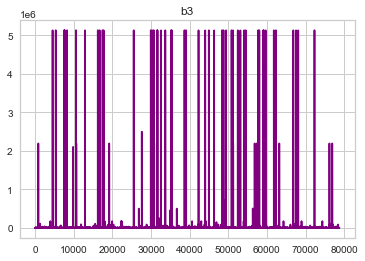

In [15]:
#plt.hist(df.b3, density = True)
plt.plot(df_original.b3, color = "purple")
plt.title("b3")
plt.show()

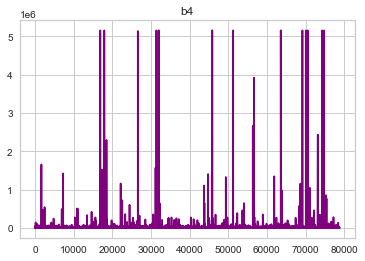

In [16]:
#plt.hist(df.b4, density = True)
plt.plot(df_original.b4, color = "purple")
plt.title("b4")
plt.show()

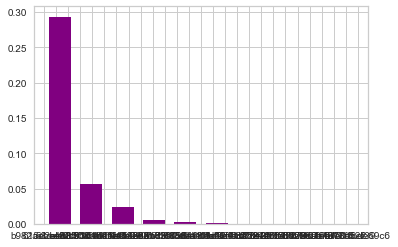

In [17]:
plt.hist(df_original.b2, color = "purple", density = True, rwidth = 0.7)
plt.show()

In [18]:
#print(np.sort(df_original.b2.unique()))

## Scatterplot Original Data

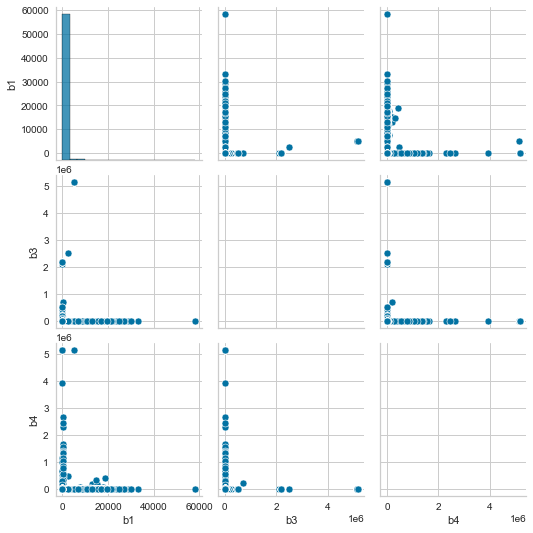

In [19]:
sns.pairplot(df_original[["b1","b2","b3","b4"]], hue=None, hue_order=None, palette=None, vars=None, x_vars=None,
              y_vars=None, kind='scatter', diag_kind='auto', markers=None)
plt.show()

## Scatterplot Transformed Data

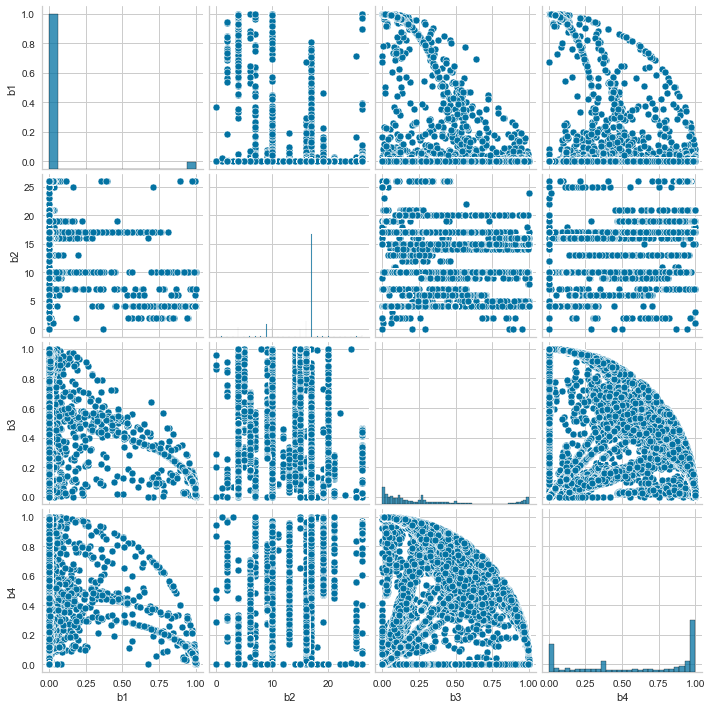

In [20]:
sns.pairplot(df_processed[["b1","b2","b3","b4"]], hue=None, hue_order=None, palette=None, vars=None, x_vars=None,
              y_vars=None, kind='scatter', diag_kind='auto', markers=None)
plt.show()

## Kurtosis of the behavioural variables

Kurtosis: [16.7244556   1.67609696  0.07454901 -1.51975071]


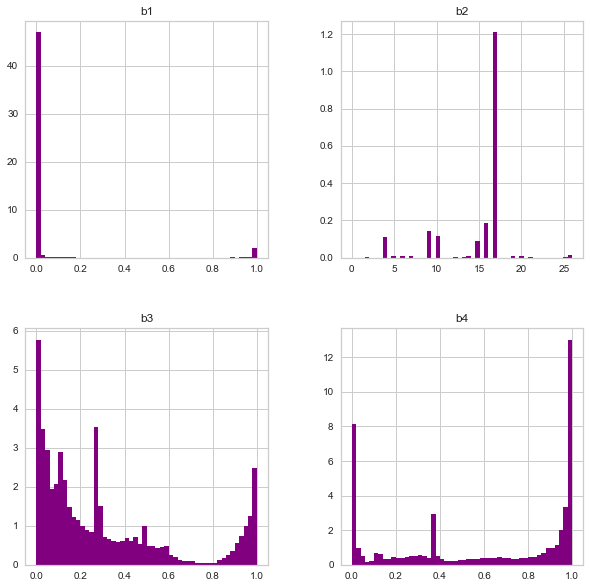

In [21]:
df_hist_ = df_processed[["b1","b2","b3","b4"]]
kur = kurtosis(df_hist_, fisher=True)
print("Kurtosis:", kur)
df_hist_.hist(figsize=(10,10), bins = 50, color = "purple", density = True)
plt.show()

# Training and Predicting: Isolation Forest

### Input Parameters

In [22]:
# n_estimators: Number of Isolation trees trained
# max_samples: Number of data points used to train each tree
# contamination: Fraction of anomalous data points, we will assume this is 1%
# max_features: Number of features to be used to train each tree
# n_jobs: The number of jobs to run in parallel for both fit and predict 
n_estimators = 50
max_samples = 500
contamination = .01

# max_features: we will keep this as by ddefault = max features
n_jobs = 1
random_state = 1 

In [25]:
anomaly = setup(data = features, silent = True)
models()

,Description,Value
0,session_id,6476
1,Original Data,"(78764, 8)"
2,Missing Values,False
3,Numeric Features,8
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(78764, 8)"
9,CPU Jobs,-1


,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


## Fitting and Predicting Anomalies

In [26]:
# defining the model
IsolationForest_model  =  IsolationForest(n_estimators, max_samples, contamination, n_jobs=1, random_state=1)

In [27]:
#fitting the model on our data
IsolationForest_model.fit(features)

# Get Anomaly Scores and Predictions
anomaly_score = IsolationForest_model.decision_function(features)
predictions = IsolationForest_model.predict(features)
df_dim_reduced["anomaly_score"] = anomaly_score
df_dim_reduced["anomaly_label"] = predictions

In [28]:
# creating dummy variable is_outlier
df_dim_reduced["is_outlier"] = df_dim_reduced["anomaly_label"].apply(lambda z: 1 if z == -1 else 0)
df_dim_reduced

,idnr,b1,b2,b3,b4,PC 1,PC 2,PC 3,PC 4,anomaly_score,anomaly_label,is_outlier
0,1,0.000000,17,0.111717,0.985012,-0.335505,-0.283181,-0.059268,0.035269,0.275962,1,0
1,2,0.000000,9,0.447397,0.617834,0.298027,1.077649,-0.048181,-0.050618,0.122399,1,0
2,3,0.000000,17,0.021192,0.999022,-0.357351,-0.307636,-0.145480,0.027962,0.273048,1,0
3,4,0.000000,17,0.152432,0.975689,-0.324380,-0.306372,-0.066071,-0.071212,0.265162,1,0
4,5,0.000000,17,0.198461,0.953975,-0.304737,-0.285632,0.009656,-0.068382,0.251393,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
78759,78760,0.000000,16,0.966916,0.221437,-0.341568,-0.280418,-0.069614,0.062787,0.221715,1,0
78760,78761,0.000000,16,0.971001,0.171076,-0.330724,-0.270356,-0.029779,0.060036,0.206304,1,0
78761,78762,0.000000,17,0.090380,0.986681,-0.334567,-0.282233,-0.055723,0.035342,0.270842,1,0
78762,78763,0.041845,10,0.739260,0.516087,0.243120,1.023344,-0.254657,-0.047789,0.042969,1,0


In [29]:
df_dim_reduced[df_dim_reduced["is_outlier"] == 1]

,idnr,b1,b2,b3,b4,PC 1,PC 2,PC 3,PC 4,anomaly_score,anomaly_label,is_outlier
17,18,0.020494,19,0.017932,0.929904,0.059695,0.317235,-0.199237,0.323701,-0.012345,-1,1
56,57,0.943402,4,0.155996,0.111425,0.171641,0.982588,-0.480855,0.050311,-0.007565,-1,1
98,99,0.000000,19,0.025795,0.821760,0.080343,0.380558,-0.060543,0.454758,-0.000495,-1,1
112,113,0.000000,20,0.112121,0.000000,0.509578,1.857019,0.066810,-0.282679,-0.004203,-1,1
309,310,0.119151,19,0.021664,0.964043,0.053701,0.277723,-0.269553,0.220283,-0.019966,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
78385,78386,0.000000,17,0.000000,0.000000,2.846256,-0.655316,0.105569,0.714176,-0.000306,-1,1
78386,78387,0.000000,17,0.000000,0.000000,4.635428,-1.622411,-0.305863,0.203307,-0.022475,-1,1
78591,78592,0.927264,4,0.176108,0.125792,0.173486,0.993160,-0.461456,0.077103,-0.016179,-1,1
78603,78604,0.000000,19,0.022349,0.890751,0.066778,0.344172,-0.144240,0.384745,-0.004193,-1,1


## Output of the case

In [30]:
# Saving the output on csv called solution.csv with two fields
# idnr: id of the sample
# is_outlier: binary field with 0: if not an outlier and 1: if outlier

In [31]:
# selecting only the id and outlier dummy variable for saving it on csv
final_df = df_dim_reduced[["idnr", "is_outlier"]]
final_df

,idnr,is_outlier
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
78759,78760,0
78760,78761,0
78761,78762,0
78762,78763,0


In [32]:
#saving the data on csv
final_df.to_csv("./Output/final_df_withPCA.csv", sep = ';', index=False)

In [36]:
final_df.groupby("is_outlier")["idnr"].count()

is_outlier
0    77976
1      788
Name: idnr, dtype: int64

## PCA for Visualization: Reducing dimension of all data points

In [37]:
# we will initially divide to 10 PCs
pca = PCA(n_components=5)
PCs = pca.fit_transform(features)
principalDf = pd.DataFrame(data = PCs, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5'])
principalDf

,PC 1,PC 2,PC 3,PC 4,PC 5
0,-2.071059,-0.311416,0.313654,-0.029263,-0.001790
1,6.054182,-0.032832,-0.013957,-0.350652,-0.135817
2,-2.074186,-0.326065,0.409738,-0.015319,0.055619
3,-2.073168,-0.299019,0.292336,0.004512,0.000943
4,-2.069887,-0.280542,0.225633,-0.016950,-0.044155
...,...,...,...,...,...
78759,-1.040455,-0.224573,-0.674726,0.480892,0.076941
78760,-1.036582,-0.202907,-0.719050,0.469889,0.066206
78761,-2.070998,-0.309280,0.328305,-0.038625,-0.002871
78762,5.065130,-0.051800,-0.270540,-0.210654,0.109250


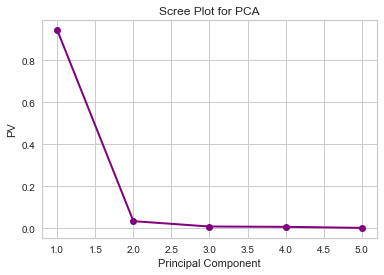

In [38]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2, color = "purple")
plt.title('Scree Plot for PCA')
plt.xlabel('Principal Component')
plt.ylabel('PV')
plt.show()

In [39]:
# cumulative percentage variance per PC
out_sum = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)*100, columns = ["cumPV%"] ) 
print ("Cumulative PV Explained: \n", out_sum)

Cumulative PV Explained: 
       cumPV%
0  94.430691
1  97.878673
2  98.768095
3  99.506937
4  99.752802


In [40]:
principalDf["is_outlier"] = final_df["is_outlier"]

# Outlier Visualization

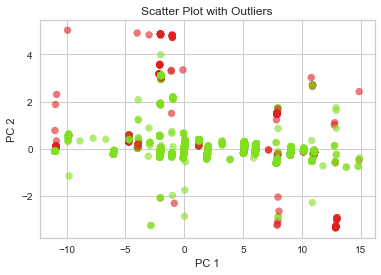

In [41]:
# green for normal point and red for outlier
colors = ['#81DF20', '#DF2020']
principalDf['c'] = principalDf.is_outlier.map({0:colors[0], 1:colors[1]})
plt.scatter(principalDf["PC 1"], principalDf["PC 2"], c=principalDf.c, alpha = 0.6)
plt.title("Scatter Plot with Outliers")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

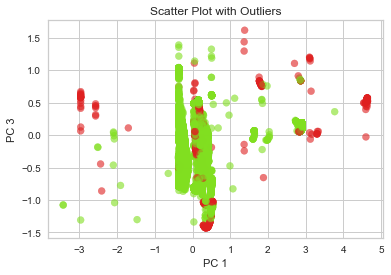

In [42]:
# green for normal point and red for outlier
colors = ['#81DF20', '#DF2020']
principalDf['c'] = principalDf.is_outlier.map({0:colors[0], 1:colors[1]})
plt.scatter(df_dim_reduced["PC 1"], principalDf["PC 3"], c=principalDf.c, alpha = 0.6)
plt.title("Scatter Plot with Outliers")
plt.xlabel("PC 1")
plt.ylabel("PC 3")
plt.show()

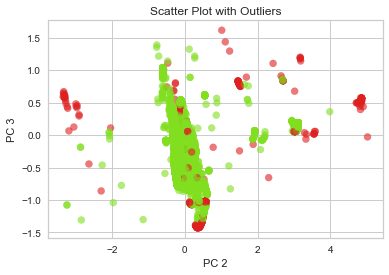

In [43]:
# green for normal point and red for outlier
colors = ['#81DF20', '#DF2020']
principalDf['c'] = principalDf.is_outlier.map({0:colors[0], 1:colors[1]})
plt.scatter(principalDf["PC 2"], principalDf["PC 3"], c=principalDf.c, alpha = 0.6)
plt.title("Scatter Plot with Outliers")
plt.xlabel("PC 2")
plt.ylabel("PC 3")
plt.show()

# Evaluation of the model: Cross Scoring

In [44]:
# getting number of observations in the original data
N = df_dim_reduced.shape[0]
print(N)

# number of not outliers in the data
N_not_outliers = df_dim_reduced[df_dim_reduced.is_outlier == 0].shape[0]
print(N_not_outliers)

# 20% of the non-outliers data for testing
N_test = int(N_not_outliers*0.2)
print(N_test)

N_test_outliers1per = int(N_test*0.01)
print(N_test_outliers1per)

78764
77976
15595
155


In [45]:
# sampling randomly 20% non-anomalous data and also storing all outliers in one place
outliers = df_dim_reduced[df_dim_reduced.is_outlier == 1]
not_outliers_test = df_dim_reduced[df_dim_reduced.is_outlier == 0].sample(N_test)

In [46]:
# what we want to to randomly select 1% non-anomalous data points from this random sample and replace them with 
# randomly selected outliers's data
target_baseline = not_outliers_test.sample(N_test_outliers1per)

#removing the slected sample from the original one
not_outliers_test_updated = not_outliers_test.drop(index = target_baseline.index)

target_baseline["idnr_notoutlier"] = target_baseline["idnr"]
target_baseline.reset_index(drop=True, inplace=True)

In [47]:
# we randomly select the same amount of 1% data from outliers to replace the target baseline non-anomalous points
selected_outliers = outliers.sample(N_test_outliers1per)
selected_outliers["idnr_outlier"] = selected_outliers["idnr"]
selected_outliers.reset_index(drop=True, inplace=True)

In [48]:
# we then switch the data of the two groups (non-anoomouls behaviour with behaviour of outliers)
switched_target = pd.concat([target_baseline[["idnr","idnr_notoutlier"]], selected_outliers[["idnr_outlier","b1", "b2", "b3", "b4","PC 1", "PC 2", "PC 3", "PC 4"]]], 1)
switched_target

,idnr,idnr_notoutlier,idnr_outlier,b1,b2,b3,b4,PC 1,PC 2,PC 3,PC 4
0,56231,56231,65288,0.000000,17,0.000000,0.000000,2.857398,-0.664887,0.118152,0.650060
1,33716,33716,56435,0.954615,4,0.143833,0.103441,0.169464,0.973022,-0.499589,0.027566
2,36089,36089,23000,0.000000,17,0.000000,0.000000,2.857725,-0.665112,0.118555,0.648304
3,61501,61501,43799,0.894127,26,0.188126,0.403833,-0.366595,-0.309203,-0.169712,0.102157
4,63706,63706,21624,0.000000,18,0.000000,0.000000,4.594208,-1.446901,-0.153083,0.866334
...,...,...,...,...,...,...,...,...,...,...,...
150,31967,31967,29819,0.961002,4,0.130080,0.092915,0.167980,0.968676,-0.509264,0.018785
151,44066,44066,38047,0.000000,19,0.029602,0.636443,0.093110,0.442171,0.057162,0.605212
152,43708,43708,43396,0.812776,4,0.274032,0.195737,0.185179,1.045164,-0.359961,0.201272
153,46664,46664,30680,0.950586,4,0.144481,0.104624,0.169939,0.977387,-0.492261,0.039567


In [49]:
# combine the orignal test data and the replaced/switched data
features_switched = switched_target[["b1","b2","b3","b4","PC 1","PC 2","PC 3", "PC 4"]]
features_switched["switched"] = 1
features_orig_test = not_outliers_test_updated[["b1","b2","b3","b4","PC 1","PC 2","PC 3", "PC 4"]]
features_orig_test["switched"] = 0
feature_ = pd.concat([features_switched,features_orig_test], 0)


In [50]:
#fitting the model on our data
IsolationForest_model.fit(feature_.drop("switched",1))

# Get Anomaly Scores and Predictions
anomaly_score = IsolationForest_model.decision_function(feature_.drop("switched",1))
predictions = IsolationForest_model.predict(feature_.drop("switched",1))
feature_["anomaly_label"] = predictions
# creating dummy variable is_outlier
feature_["is_outlier"] = feature_["anomaly_label"].apply(lambda z: 1 if z == -1 else 0)

In [51]:
# creating dummy variable is_outlier
feature_["is_outlier"] = feature_["anomaly_label"].apply(lambda z: 1 if z == -1 else 0)
feature_

,b1,b2,b3,b4,PC 1,PC 2,PC 3,PC 4,switched,anomaly_label,is_outlier
0,0.000000,17,0.000000,0.000000,2.857398,-0.664887,0.118152,0.650060,1,-1,1
1,0.954615,4,0.143833,0.103441,0.169464,0.973022,-0.499589,0.027566,1,1,0
2,0.000000,17,0.000000,0.000000,2.857725,-0.665112,0.118555,0.648304,1,-1,1
3,0.894127,26,0.188126,0.403833,-0.366595,-0.309203,-0.169712,0.102157,1,-1,1
4,0.000000,18,0.000000,0.000000,4.594208,-1.446901,-0.153083,0.866334,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...
17758,0.000462,16,0.984017,0.150143,-0.343672,-0.292912,-0.092341,0.030736,0,1,0
43838,0.000000,17,0.539120,0.717163,-0.245414,-0.253263,0.195590,-0.155829,0,1,0
43288,0.000000,17,0.004810,0.999973,-0.365038,-0.317481,-0.177581,0.021598,0,1,0
57047,0.000000,16,0.942760,0.282140,-0.317675,-0.293715,-0.032310,-0.052817,0,1,0


## Calculating Accuracy Meassure

In [52]:
# observations that had inded anomalies behaviour and we switched them and that the model accuratly predcited as outlier
TP = feature_[((feature_.switched == 1) & (feature_.is_outlier == 1))]["b1"].count()

# observations which are not outlier but have been identified as outliers
FP = feature_[((feature_.switched == 0) & (feature_.is_outlier == 1))]["b1"].count()

# observations which are not outlier but have been identified as non-outliers
TN = feature_[((feature_.switched == 0) & (feature_.is_outlier == 0))]["b1"].count()

# observations which are not outlier but have been identified as non-outliers
FN = feature_[((feature_.switched == 1) & (feature_.is_outlier == 0))]["b1"].count()

TPR = TP/(TP +FN)*100
print("True Positive Rate:" + str(round(TPR)) + "%")

FPR = FP/(FP +TN)*100
print("False Positive Rate:" + str(round(FPR)) + "%")

TNR = 100 - FPR
print("True Negative Rate:" + str(round(TNR)) + "%")

FNR = 100- TPR
print("False Negative Rate:" + str(round(FNR)) + "%")

P = TP/(TP + FP)
print("Precision:" + str(P))

R = TP/(TP + FN)
print("Recall:" + str(R))

F1 = 2 * P * R/(R+P)
print("F1 Score:" + str(F1))

True Positive Rate:69%
False Positive Rate:0%
True Negative Rate:100%
False Negative Rate:31%
Precision:0.7039473684210527
Recall:0.6903225806451613
F1 Score:0.6970684039087947
